# Data Modeling

In [1]:
from warnings import filterwarnings

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

filterwarnings(action='ignore')

/Users/marinakupina/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
df_final = pd.read_csv('Data/All_aggregations_hourly_UR_updates.csv',index_col=0)

In [3]:
df_final['Date_x'] = pd.to_datetime(df_final['Date_x'], format='%Y-%m-%dT%H:%M:%S')
df_final['Hours'] = df_final['Date_x'].dt.hour

In [4]:
col_drop = [
    'Inverter_1',
    'Inverter_2',
    'Inverter_3',
    'Inverter_4',
    'Inverter_5',
    'Inverter_6',
    'Inverter_7',
    'Inverter_8',
    'Electric_KWAC_Power_min',
    'Electric_KWAC_Power_max',
    'Electric_KWAC_Power_mean',
    'Electric_KWAC_Power_median',
    'Electric_KWAC_Power_std',
    'Electric_KWAC_Power_sum',
    'Inverter_1_min',
    'Inverter_1_max',
    'Inverter_1_mean',
    'Inverter_1_median',
    'Inverter_1_std',
    'Inverter_1_sum',
    'Inverter_2_min',
    'Inverter_2_max',
    'Inverter_2_mean',
    'Inverter_2_median',
    'Inverter_2_std',
    'Inverter_2_sum',
    'Inverter_3_min',
    'Inverter_3_max',
    'Inverter_3_mean',
    'Inverter_3_median',
    'Inverter_3_std',
    'Inverter_3_sum',
    'Inverter_4_min',
    'Inverter_4_max',
    'Inverter_4_mean',
    'Inverter_4_median',
    'Inverter_4_std',
    'Inverter_4_sum',
    'Inverter_5_min',
    'Inverter_5_max',
    'Inverter_5_mean',
    'Inverter_5_median',
    'Inverter_5_std',
    'Inverter_5_sum',
    'Inverter_6_min',
    'Inverter_6_max',
    'Inverter_6_mean',
    'Inverter_6_median',
    'Inverter_6_std',
    'Inverter_6_sum',
    'Inverter_7_min',
    'Inverter_7_max',
    'Inverter_7_mean',
    'Inverter_7_median',
    'Inverter_7_std',
    'Inverter_7_sum',
    'Inverter_8_min',
    'Inverter_8_max',
    'Inverter_8_mean',
    'Inverter_8_median',
    'Inverter_8_std',
    'Inverter_8_sum',
    'Date_x',
    'Date_ymd',
    'Date_y',
    'Solar.Noon',
    'HourlyWindDirection',
    'HourlyWindDirection_max',
    'HourlyWindDirection_min',
    'HourlyWindDirection_mean',
    'HourlyWindDirection_std',
    'HourlyWindDirection_median',
    'HourlyAltimeterSetting',
    'HourlyPrecipitation',
    'HourlySeaLevelPressure',
    'HourlyStationPressure',
    'HourlyVisibility',
    'True.Solar.Time.Minutes',
    'Solar.Zenith.Angle',
    'Solar.Elevation.Angle',
    'Solar.Azimuth.Degrees.From.North',
    'Power_mean_deviation_June21',
    'Power_sum_deviation_June21',
    'Days_Jan1',
    'HourlyAltimeterSetting',
    'HourlyAltimeterSetting_min',
    'HourlyAltimeterSetting_max',
    'HourlyAltimeterSetting_mean',
    'HourlyAltimeterSetting_median',
    'HourlyAltimeterSetting_std',
    'HourlyVisibility_mean',
    'True.Solar.Time.Minutes',
    'Days_Jan1',
    'SkyConditions_level_min',
    'SkyConditions_level_max',
    'SkyConditions_level_mean',
    'SkyConditions_level_median',
    'SkyConditions_level_std',
]

In [5]:
df_final.HourlyWindDirection.replace('VRB',0,inplace=True)
df_final.HourlyWindDirection = df_final.HourlyWindDirection.astype(int)

In [6]:
df_final['WindDirection_cat'] = df_final.HourlyWindDirection.apply(
    lambda x: 'east' if x >= 45 and x < 135 else
    ('south' if x >= 135 and x < 225 else
     ('west' if x >= 225 and x < 315 else 'north'))).copy()

In [7]:
df_final = df_final.drop(col_drop,axis=1)

In [8]:
df_final.rename(columns={'Electric_KWAC_Power':'Power'}, inplace=True)

In [9]:
dataset = df_final
dataset.Power = dataset.Power.apply(lambda x: abs(x))

In [10]:
X = dataset
X = pd.concat([X, pd.get_dummies(X[['WindDirection_cat']], prefix='WindDirection')],axis=1)
X = pd.concat([X, pd.get_dummies(X[['SkyConditions_level']].astype(str),
                   prefix='SkyConditions')], axis=1)
y = dataset['Power'].values.astype('float32')

# now drop the original 'country' column (you don't need it anymore)
X.drop(['WindDirection_cat', 'SkyConditions_level', 'Power'],
       axis=1,
       inplace=True)

In [11]:
# Create training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=False)

In [12]:
# Transform to XGBoost format
D_train_1 = xgb.DMatrix(X_train, label=y_train)
D_val_1 = xgb.DMatrix(X_val, label=y_val)
D_test_1 = xgb.DMatrix(X_test, label=y_test)

## XGBoost

In [13]:
xgb_params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'min_child_weight': 1,
    'learning_rate': 0.05,
    'alpha': 0.5,
}

min_rmse = float("Inf")
best_params = None
num_boost_round = 2000

gridsearch_params = [(max_depth, min_child_weight, learning_rate)
                     for max_depth in range(6, 9)
                     for min_child_weight in range(6, 9)
                     for learning_rate in [0.05, 0.01]]

for max_depth, min_child_weight, learning_rate in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}, learning_rate={}".format(
        max_depth, min_child_weight, learning_rate))
    # Update our parameters
    xgb_params['max_depth'] = max_depth
    xgb_params['min_child_weight'] = min_child_weight
    xgb_params['learning_rate'] = learning_rate
    # Run CV
    cv_results = xgb.cv(xgb_params,
                        D_train_1,
                        num_boost_round=num_boost_round,
                        seed=42,
                        nfold=5,
                        early_stopping_rounds=1000)
    # Update best MSE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth, min_child_weight, learning_rate)

print("Best params: {}, {}, {} RMSE: {}".format(best_params[0], best_params[1],
                                                best_params[2], min_rmse))

CV with max_depth=6, min_child_weight=6, learning_rate=0.05
	RMSE 15.550797600000001 for 1979 rounds
CV with max_depth=6, min_child_weight=6, learning_rate=0.01
	RMSE 15.935415799999998 for 1999 rounds
CV with max_depth=6, min_child_weight=7, learning_rate=0.05
	RMSE 15.6386776 for 1999 rounds
CV with max_depth=6, min_child_weight=7, learning_rate=0.01
	RMSE 15.9433232 for 1987 rounds
CV with max_depth=6, min_child_weight=8, learning_rate=0.05
	RMSE 15.6279502 for 1987 rounds
CV with max_depth=6, min_child_weight=8, learning_rate=0.01
	RMSE 15.9901082 for 1999 rounds
CV with max_depth=7, min_child_weight=6, learning_rate=0.05
	RMSE 15.338136600000002 for 1998 rounds
CV with max_depth=7, min_child_weight=6, learning_rate=0.01
	RMSE 15.471573600000003 for 1982 rounds
CV with max_depth=7, min_child_weight=7, learning_rate=0.05
	RMSE 15.5116976 for 1999 rounds
CV with max_depth=7, min_child_weight=7, learning_rate=0.01
	RMSE 15.5414016 for 1999 rounds
CV with max_depth=7, min_child_weight=

In [14]:
xgb_params['max_depth'] = 6
xgb_params['min_child_weight'] = 6
xgb_params['learning_rate'] = 0.05

In [15]:
model_1 = xgb.train(xgb_params,
                    D_train_1,
                    num_boost_round=5000,
                    evals=[(D_val_1, "Val")],
                    early_stopping_rounds=1000)
print("Best MSE: {:.2f} in {} rounds".format(model_1.best_score,
                                             model_1.best_iteration + 1))

[0]	Val-rmse:94.0998
Will train until Val-rmse hasn't improved in 1000 rounds.
[1]	Val-rmse:89.8228
[2]	Val-rmse:85.742
[3]	Val-rmse:81.9478
[4]	Val-rmse:78.3697
[5]	Val-rmse:74.9506
[6]	Val-rmse:71.7244
[7]	Val-rmse:68.6444
[8]	Val-rmse:65.6506
[9]	Val-rmse:62.8521
[10]	Val-rmse:60.1838
[11]	Val-rmse:57.5896
[12]	Val-rmse:55.2063
[13]	Val-rmse:52.98
[14]	Val-rmse:50.8423
[15]	Val-rmse:48.8035
[16]	Val-rmse:46.8586
[17]	Val-rmse:45.0529
[18]	Val-rmse:43.3514
[19]	Val-rmse:41.7436
[20]	Val-rmse:40.1838
[21]	Val-rmse:38.6648
[22]	Val-rmse:37.3138
[23]	Val-rmse:36.0197
[24]	Val-rmse:34.7979
[25]	Val-rmse:33.6827
[26]	Val-rmse:32.5746
[27]	Val-rmse:31.5423
[28]	Val-rmse:30.6402
[29]	Val-rmse:29.8254
[30]	Val-rmse:28.9673
[31]	Val-rmse:28.0849
[32]	Val-rmse:27.276
[33]	Val-rmse:26.4906
[34]	Val-rmse:25.77
[35]	Val-rmse:25.0857
[36]	Val-rmse:24.4234
[37]	Val-rmse:23.7433
[38]	Val-rmse:23.1642
[39]	Val-rmse:22.5728
[40]	Val-rmse:22.108
[41]	Val-rmse:21.5743
[42]	Val-rmse:21.0968
[43]	Val-rmse

[361]	Val-rmse:12.0598
[362]	Val-rmse:12.0607
[363]	Val-rmse:12.0643
[364]	Val-rmse:12.0611
[365]	Val-rmse:12.0612
[366]	Val-rmse:12.0633
[367]	Val-rmse:12.0606
[368]	Val-rmse:12.0602
[369]	Val-rmse:12.0582
[370]	Val-rmse:12.0556
[371]	Val-rmse:12.0537
[372]	Val-rmse:12.0541
[373]	Val-rmse:12.055
[374]	Val-rmse:12.0546
[375]	Val-rmse:12.056
[376]	Val-rmse:12.0577
[377]	Val-rmse:12.0579
[378]	Val-rmse:12.0545
[379]	Val-rmse:12.0563
[380]	Val-rmse:12.0602
[381]	Val-rmse:12.0593
[382]	Val-rmse:12.0766
[383]	Val-rmse:12.0768
[384]	Val-rmse:12.0741
[385]	Val-rmse:12.0729
[386]	Val-rmse:12.0778
[387]	Val-rmse:12.0864
[388]	Val-rmse:12.0831
[389]	Val-rmse:12.0875
[390]	Val-rmse:12.0773
[391]	Val-rmse:12.1023
[392]	Val-rmse:12.1015
[393]	Val-rmse:12.1039
[394]	Val-rmse:12.1225
[395]	Val-rmse:12.1197
[396]	Val-rmse:12.1249
[397]	Val-rmse:12.1277
[398]	Val-rmse:12.1305
[399]	Val-rmse:12.1345
[400]	Val-rmse:12.1339
[401]	Val-rmse:12.1331
[402]	Val-rmse:12.137
[403]	Val-rmse:12.1367
[404]	Val-rmse

[720]	Val-rmse:12.3307
[721]	Val-rmse:12.3307
[722]	Val-rmse:12.3312
[723]	Val-rmse:12.3312
[724]	Val-rmse:12.3282
[725]	Val-rmse:12.3274
[726]	Val-rmse:12.327
[727]	Val-rmse:12.3267
[728]	Val-rmse:12.3291
[729]	Val-rmse:12.3295
[730]	Val-rmse:12.3299
[731]	Val-rmse:12.3318
[732]	Val-rmse:12.332
[733]	Val-rmse:12.331
[734]	Val-rmse:12.3308
[735]	Val-rmse:12.334
[736]	Val-rmse:12.3339
[737]	Val-rmse:12.3337
[738]	Val-rmse:12.3338
[739]	Val-rmse:12.3343
[740]	Val-rmse:12.3335
[741]	Val-rmse:12.3349
[742]	Val-rmse:12.3351
[743]	Val-rmse:12.3341
[744]	Val-rmse:12.3335
[745]	Val-rmse:12.3336
[746]	Val-rmse:12.3279
[747]	Val-rmse:12.3286
[748]	Val-rmse:12.328
[749]	Val-rmse:12.3285
[750]	Val-rmse:12.3293
[751]	Val-rmse:12.3285
[752]	Val-rmse:12.3277
[753]	Val-rmse:12.321
[754]	Val-rmse:12.3211
[755]	Val-rmse:12.319
[756]	Val-rmse:12.3172
[757]	Val-rmse:12.3233
[758]	Val-rmse:12.3242
[759]	Val-rmse:12.3267
[760]	Val-rmse:12.3273
[761]	Val-rmse:12.3261
[762]	Val-rmse:12.3213
[763]	Val-rmse:12.

[1075]	Val-rmse:12.2098
[1076]	Val-rmse:12.2034
[1077]	Val-rmse:12.2049
[1078]	Val-rmse:12.2044
[1079]	Val-rmse:12.2043
[1080]	Val-rmse:12.204
[1081]	Val-rmse:12.2054
[1082]	Val-rmse:12.2058
[1083]	Val-rmse:12.2058
[1084]	Val-rmse:12.206
[1085]	Val-rmse:12.2184
[1086]	Val-rmse:12.2188
[1087]	Val-rmse:12.2189
[1088]	Val-rmse:12.2189
[1089]	Val-rmse:12.2181
[1090]	Val-rmse:12.218
[1091]	Val-rmse:12.218
[1092]	Val-rmse:12.2178
[1093]	Val-rmse:12.218
[1094]	Val-rmse:12.2177
[1095]	Val-rmse:12.218
[1096]	Val-rmse:12.2186
[1097]	Val-rmse:12.2187
[1098]	Val-rmse:12.2198
[1099]	Val-rmse:12.2194
[1100]	Val-rmse:12.2223
[1101]	Val-rmse:12.2229
[1102]	Val-rmse:12.2229
[1103]	Val-rmse:12.2228
[1104]	Val-rmse:12.224
[1105]	Val-rmse:12.224
[1106]	Val-rmse:12.2243
[1107]	Val-rmse:12.2242
[1108]	Val-rmse:12.2249
[1109]	Val-rmse:12.225
[1110]	Val-rmse:12.225
[1111]	Val-rmse:12.2217
[1112]	Val-rmse:12.2192
[1113]	Val-rmse:12.2225
[1114]	Val-rmse:12.2228
[1115]	Val-rmse:12.2225
[1116]	Val-rmse:12.2231
[1

In [16]:
num_boost_round = model_1.best_iteration + 1
best_model_1 = xgb.train(xgb_params,
                         D_train_1,
                         num_boost_round=num_boost_round,
                         evals=[(D_val_1, "Val")])

print('The R^2 score is:', r2_score(best_model_1.predict(D_test_1), y_test))

[0]	Val-rmse:94.0998
[1]	Val-rmse:89.8228
[2]	Val-rmse:85.742
[3]	Val-rmse:81.9478
[4]	Val-rmse:78.3697
[5]	Val-rmse:74.9506
[6]	Val-rmse:71.7244
[7]	Val-rmse:68.6444
[8]	Val-rmse:65.6506
[9]	Val-rmse:62.8521
[10]	Val-rmse:60.1838
[11]	Val-rmse:57.5896
[12]	Val-rmse:55.2063
[13]	Val-rmse:52.98
[14]	Val-rmse:50.8423
[15]	Val-rmse:48.8035
[16]	Val-rmse:46.8586
[17]	Val-rmse:45.0529
[18]	Val-rmse:43.3514
[19]	Val-rmse:41.7436
[20]	Val-rmse:40.1838
[21]	Val-rmse:38.6648
[22]	Val-rmse:37.3138
[23]	Val-rmse:36.0197
[24]	Val-rmse:34.7979
[25]	Val-rmse:33.6827
[26]	Val-rmse:32.5746
[27]	Val-rmse:31.5423
[28]	Val-rmse:30.6402
[29]	Val-rmse:29.8254
[30]	Val-rmse:28.9673
[31]	Val-rmse:28.0849
[32]	Val-rmse:27.276
[33]	Val-rmse:26.4906
[34]	Val-rmse:25.77
[35]	Val-rmse:25.0857
[36]	Val-rmse:24.4234
[37]	Val-rmse:23.7433
[38]	Val-rmse:23.1642
[39]	Val-rmse:22.5728
[40]	Val-rmse:22.108
[41]	Val-rmse:21.5743
[42]	Val-rmse:21.0968
[43]	Val-rmse:20.6603
[44]	Val-rmse:20.2345
[45]	Val-rmse:19.8077
[46]	

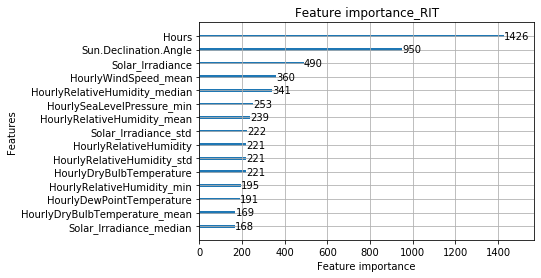

<Figure size 1152x864 with 0 Axes>

In [17]:
xgb.plot_importance(best_model_1,
                    title='Feature importance_RIT',
                    max_num_features=15,
                    xlabel='Feature importance')
plt.figure(figsize=(16, 12))
plt.show()

## LightGBM

In [18]:
# Transform to XGBoost format
D_train_2 = lgb.Dataset(X_train, label=y_train)
D_val_2 = lgb.Dataset(X_val, label=y_val)
D_test_2 = lgb.Dataset(X_test, label=y_test)

In [19]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': "rmse",
    # Parameters that we are going to tune.
    'max_depth': 6,
    'min_child_weight': 1,
    'learning_rate': 0.05,
}

min_rmse = float("Inf")
best_params = None
num_boost_round = 9999

gridsearch_params = [(max_depth, min_child_weight, learning_rate)
                     for max_depth in range(5, 6)
                     for min_child_weight in range(5, 7)
                     for learning_rate in [0.1]]

for max_depth, min_child_weight, learning_rate in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}, learning_rate={}".format(
        max_depth, min_child_weight, learning_rate))
    # Update our parameters
    lgb_params['max_depth'] = max_depth
    lgb_params['min_child_weight'] = min_child_weight
    lgb_params['learning_rate'] = learning_rate
    # Run CV
    cv_results = lgb.cv(lgb_params,
                        D_train_2,
                        num_boost_round=num_boost_round,
                        seed=42,
                        nfold=5,
                        verbose_eval=20,
                        early_stopping_rounds=500,
                        stratified=False)
    # Update best MSE
    mean_rmse = min(cv_results['rmse-mean'])
    #boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\t RMSE {}".format(mean_rmse))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth, min_child_weight, learning_rate)

print("Best params: {}, {},{} RMSE: {}".format(best_params[0], best_params[1],
                                               best_params[2], min_rmse))

CV with max_depth=5, min_child_weight=5, learning_rate=0.1
[20]	cv_agg's rmse: 25.1977 + 1.93636
[40]	cv_agg's rmse: 19.3813 + 1.61035
[60]	cv_agg's rmse: 18.1785 + 1.34496
[80]	cv_agg's rmse: 17.7493 + 1.34929
[100]	cv_agg's rmse: 17.4894 + 1.34569
[120]	cv_agg's rmse: 17.3026 + 1.35066
[140]	cv_agg's rmse: 17.1826 + 1.34283
[160]	cv_agg's rmse: 17.108 + 1.29726
[180]	cv_agg's rmse: 17.0225 + 1.28083
[200]	cv_agg's rmse: 16.968 + 1.26577
[220]	cv_agg's rmse: 16.9126 + 1.22436
[240]	cv_agg's rmse: 16.8854 + 1.20822
[260]	cv_agg's rmse: 16.8482 + 1.18962
[280]	cv_agg's rmse: 16.804 + 1.18813
[300]	cv_agg's rmse: 16.7655 + 1.18262
[320]	cv_agg's rmse: 16.7555 + 1.16891
[340]	cv_agg's rmse: 16.7121 + 1.14721
[360]	cv_agg's rmse: 16.6899 + 1.12
[380]	cv_agg's rmse: 16.6647 + 1.10804
[400]	cv_agg's rmse: 16.6515 + 1.10181
[420]	cv_agg's rmse: 16.6276 + 1.09405
[440]	cv_agg's rmse: 16.6148 + 1.10085
[460]	cv_agg's rmse: 16.6059 + 1.08419
[480]	cv_agg's rmse: 16.6062 + 1.06994
[500]	cv_agg's 

In [20]:
lgb_params['max_depth'] = 5
lgb_params['min_child_weight'] = 5
lgb_params['learning_rate'] = 0.1

In [21]:
model_2 = lgb.train(lgb_params,
                    D_train_2,
                    num_boost_round=num_boost_round,
                    early_stopping_rounds=500,
                    valid_sets=D_val_2)

[1]	valid_0's rmse: 72.1711
Training until validation scores don't improve for 500 rounds
[2]	valid_0's rmse: 66.1121
[3]	valid_0's rmse: 60.6476
[4]	valid_0's rmse: 55.7703
[5]	valid_0's rmse: 51.404
[6]	valid_0's rmse: 47.3615
[7]	valid_0's rmse: 43.7243
[8]	valid_0's rmse: 40.4698
[9]	valid_0's rmse: 37.5373
[10]	valid_0's rmse: 34.8211
[11]	valid_0's rmse: 32.6472
[12]	valid_0's rmse: 30.5494
[13]	valid_0's rmse: 28.7297
[14]	valid_0's rmse: 26.962
[15]	valid_0's rmse: 25.3792
[16]	valid_0's rmse: 24.1446
[17]	valid_0's rmse: 23.0259
[18]	valid_0's rmse: 21.858
[19]	valid_0's rmse: 20.6472
[20]	valid_0's rmse: 19.5966
[21]	valid_0's rmse: 18.6928
[22]	valid_0's rmse: 17.7884
[23]	valid_0's rmse: 16.9616
[24]	valid_0's rmse: 16.2973
[25]	valid_0's rmse: 15.9217
[26]	valid_0's rmse: 15.601
[27]	valid_0's rmse: 15.3454
[28]	valid_0's rmse: 14.8169
[29]	valid_0's rmse: 14.3124
[30]	valid_0's rmse: 13.772
[31]	valid_0's rmse: 13.5572
[32]	valid_0's rmse: 13.3363
[33]	valid_0's rmse: 13.

[278]	valid_0's rmse: 12.4561
[279]	valid_0's rmse: 12.4619
[280]	valid_0's rmse: 12.4626
[281]	valid_0's rmse: 12.4621
[282]	valid_0's rmse: 12.4605
[283]	valid_0's rmse: 12.4596
[284]	valid_0's rmse: 12.4572
[285]	valid_0's rmse: 12.462
[286]	valid_0's rmse: 12.4512
[287]	valid_0's rmse: 12.4493
[288]	valid_0's rmse: 12.4475
[289]	valid_0's rmse: 12.4525
[290]	valid_0's rmse: 12.4589
[291]	valid_0's rmse: 12.4579
[292]	valid_0's rmse: 12.4599
[293]	valid_0's rmse: 12.4717
[294]	valid_0's rmse: 12.4713
[295]	valid_0's rmse: 12.4659
[296]	valid_0's rmse: 12.4635
[297]	valid_0's rmse: 12.4656
[298]	valid_0's rmse: 12.4606
[299]	valid_0's rmse: 12.4669
[300]	valid_0's rmse: 12.4777
[301]	valid_0's rmse: 12.4735
[302]	valid_0's rmse: 12.4594
[303]	valid_0's rmse: 12.458
[304]	valid_0's rmse: 12.455
[305]	valid_0's rmse: 12.4502
[306]	valid_0's rmse: 12.4485
[307]	valid_0's rmse: 12.4472
[308]	valid_0's rmse: 12.4563
[309]	valid_0's rmse: 12.4548
[310]	valid_0's rmse: 12.456
[311]	valid_0'

In [22]:
num_boost_round = model_2.best_iteration + 1
best_model_2 = lgb.train(lgb_params,
                         D_train_2,
                         num_boost_round=num_boost_round,
                         valid_sets=D_val_2)

[1]	valid_0's rmse: 72.1711
[2]	valid_0's rmse: 66.1121
[3]	valid_0's rmse: 60.6476
[4]	valid_0's rmse: 55.7703
[5]	valid_0's rmse: 51.404
[6]	valid_0's rmse: 47.3615
[7]	valid_0's rmse: 43.7243
[8]	valid_0's rmse: 40.4698
[9]	valid_0's rmse: 37.5373
[10]	valid_0's rmse: 34.8211
[11]	valid_0's rmse: 32.6472
[12]	valid_0's rmse: 30.5494
[13]	valid_0's rmse: 28.7297
[14]	valid_0's rmse: 26.962
[15]	valid_0's rmse: 25.3792
[16]	valid_0's rmse: 24.1446
[17]	valid_0's rmse: 23.0259
[18]	valid_0's rmse: 21.858
[19]	valid_0's rmse: 20.6472
[20]	valid_0's rmse: 19.5966
[21]	valid_0's rmse: 18.6928
[22]	valid_0's rmse: 17.7884
[23]	valid_0's rmse: 16.9616
[24]	valid_0's rmse: 16.2973
[25]	valid_0's rmse: 15.9217
[26]	valid_0's rmse: 15.601
[27]	valid_0's rmse: 15.3454
[28]	valid_0's rmse: 14.8169
[29]	valid_0's rmse: 14.3124
[30]	valid_0's rmse: 13.772
[31]	valid_0's rmse: 13.5572
[32]	valid_0's rmse: 13.3363
[33]	valid_0's rmse: 13.2126
[34]	valid_0's rmse: 12.955
[35]	valid_0's rmse: 12.8867


In [23]:
print('The R^2 score is:', r2_score(best_model_2.predict(X_test), y_test))

The R^2 score is: 0.7988036844862407


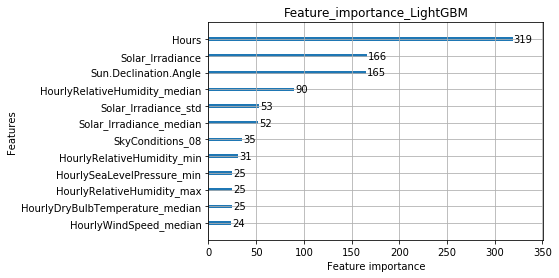

In [24]:
lgb.plot_importance(best_model_2,
                    title='Feature_importance_LightGBM',
                    importance_type='split',
                    max_num_features=12)